In [113]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from os.path import isdir, isfile, basename
from os import mkdir
import urllib
from io import StringIO, BytesIO

# モデルの評価とハイパーパラメータのチューニングのベストプラクティス

* モデルの性能の偏りのない推定量の算出
* 機械学習のアルゴリズムに共通する問題の診断
* 機械学習のモデルのチューニング
* さまざまな性能指標による予測モデルの評価

## 本題の前に、`scikit-learn.Pipeline` の紹介
<img src="images/06_01.png" />

# 機械学習の前処理

1. データの標準化
2. 特徴量の次元削減
3. 分類器へ入力

一連の流れを `pipeline` として定義する。

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model  import LogisticRegression
from sklearn.pipeline import Pipeline

# スケーリング -> PCA(次元削減) -> ロジスティック回帰　のパイプライン
pipe_lr = Pipeline([('Sclaer', StandardScaler()),
                    ('Decomposition', PCA(n_components=5)),
                    ('Classifier', LogisticRegression(random_state=1))])

## データの準備

### データの読み込み

In [81]:
# 乳癌のデータセットを読み込む
DATAFILE = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
DATACACHE = 'cache/' + basename(DATAFILE)
if isfile(DATACACHE):
    df = pd.read_csv(DATACACHE, header=None)
else:
    req = urllib.request.urlopen(DATAFILE)
    data = req.read()

    df = pd.read_csv(BytesIO(data), header=None)
    if not isdir('cache'):
        mkdir('cache')
    with open(DATACACHE, "wb") as cache:
        cache.write(data)
    
# 0列目 id
# 1列目 診断結果 M:悪性 B:良性
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### クラスラベルの数値化
4 章で紹介した LabelEncoder を用いている

In [ ]:
from sklearn.preprocessing import LabelEncoder
# df.loc のスライス指定には (slice(None, None, None), slice(2, None, None)) が渡されている
# sliceオブジェクトは [begin, end) の区間と step を表している。下記例では
# - 0 番目のインデックスについては区間指定無し(全域)
# - 1 番目のインデックスについては2から最後まで

# 実際は loc を経由しなくても df.values[:, 2:] で同じデータは得られる
X = df.loc[:, 2:].values

# 1 列目(クラスラベル)のみ取り出す
y_orig = df.loc[:, 1].values # クラスラベル ('M' or 'B')
le = LabelEncoder()
y = le.fit_transform(y_orig) # 数値にエンコードしたクラスラベル ('1' or '0')

どのようにラベルがエンコードされるかは `LabelEncoder.tranform` メソッドで確認できる。

In [86]:
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [82]:
# 学習データとテストデータに分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## 学習と分類の実行

In [83]:
pipe_lr.fit(X_train, y_train) # fit メソッドで学習
print("Test accuracy: %.3f" % pipe_lr.score(X_test, y_test))

Test accuracy: 0.974


# 本題 -学習したモデルの性能評価-

## ホールド・アウト法

## k 分割交差検証

In [96]:
from sklearn.model_selection import StratifiedKFold

# 分割元データ、分割数、乱数生成器の状態を指定し、
# 層化 k 分割交差検証イテレータを表す StratifiedKFold クラスをインスタンス化する
# version >= 0.19 では API が変更されている。
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)

scores = []
# イテレータのインデックスと要素をループ処理
for k, (train, test) in enumerate(kfold):
    # データをモデルに適合
    pipe_lr.fit(X_train[train], y_train[train])
    # テストデータの正解率を算出
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %02d, Class dist.: %s, Acc: %.3f' %
         (k + 1, np.bincount(y_train[train]), score))
    
# 正解率の平均と標準偏差を出力
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 01, Class dist.: [256 153], Acc: 0.935
Fold: 02, Class dist.: [256 153], Acc: 0.957
Fold: 03, Class dist.: [256 153], Acc: 0.978
Fold: 04, Class dist.: [256 153], Acc: 0.935
Fold: 05, Class dist.: [256 153], Acc: 0.978
Fold: 06, Class dist.: [257 153], Acc: 1.000
Fold: 07, Class dist.: [257 153], Acc: 0.978
Fold: 08, Class dist.: [257 153], Acc: 0.978
Fold: 09, Class dist.: [257 153], Acc: 1.000
Fold: 10, Class dist.: [257 153], Acc: 0.978
CV accuracy: 0.972 +/- 0.022


In [107]:
from sklearn.model_selection import cross_val_score

scores_cv = cross_val_score(estimator=pipe_lr,
                           X=X_train,
                           y=y_train,
                           cv=10,
                           n_jobs=1)

print('CV accuracy scores: %s' % scores_cv)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_cv), np.std(scores_cv)))

CV accuracy scores: [0.93478261 0.95652174 0.97826087 0.93478261 0.97826087 1.
 0.97777778 0.97777778 1.         0.97777778]
CV accuracy: 0.972 +/- 0.022


# 学習曲線と検証曲線によるアルゴリズムの診断

## 学習曲線を使ってバイアスとバリアンスの問題を診断する

In [193]:
from sklearn.learning_curve import learning_curve
pipe_lr = Pipeline([('Scaler', StandardScaler()),
                    ('Classifier', LogisticRegression(penalty='l2', random_state=0))])

def draw_learning_curve():
    train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train,
                                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                                            cv=10, n_jobs=1)

    train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
    test_mean, test_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111)
    ax.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    ax.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                    alpha=0.15, color='blue')
    
    ax.plot(train_sizes, test_mean, color='green', linestyle='--',
            marker='s', markersize=5, label='validation accuracy')
    ax.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                    alpha=0.15, color='green')
    ax.grid()
    ax.set_xlabel('Number of training samples', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=20)
      
    ax.legend(loc='lower right', fontsize=15)
    ax.set_ylim((0.8, 1.0))
    for ticks in ax.xaxis.get_major_ticks():
        ticks.label.set_fontsize(15)
    for ticks in ax.yaxis.get_major_ticks():
        ticks.label.set_fontsize(15)
    plt.show()

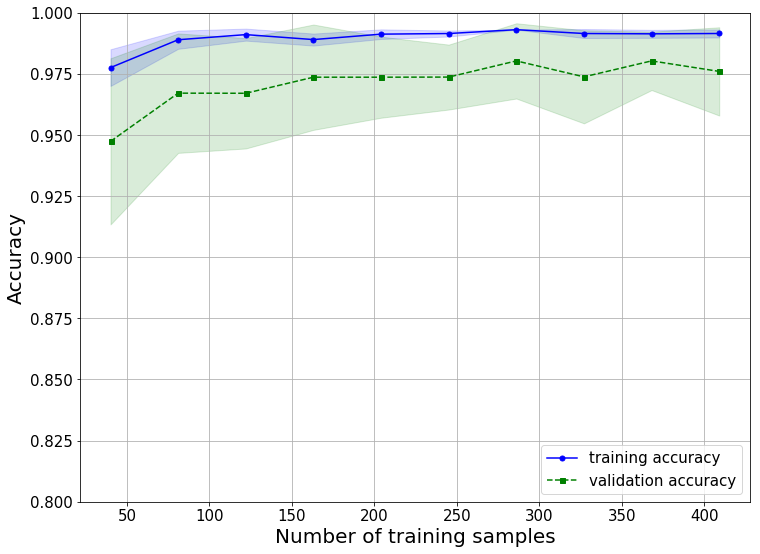

In [194]:
draw_learning_curve()

## 検証曲線を使って過学習と学習不足を明らかにする

# グリッドサーチによる機械学習モデルのチューニング

# 様々な評価指標